In [2]:
import deepSI
from deepSI import System_data, System_data_list
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
import matplotlib
import os

from scipy.io import loadmat
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from encoder_LPV_models import LPV_multi_encoder, LPV_single_encoder

In [3]:
#Remove exp_p
#3 Cases with 
# * Single use encoder
# * Multi measured encoder -> simulation with model output
# * Multi model    encoder -> simulation with model output
# - SS_encoder
# Sent data and bit of a figure.
# csv .mat
def loadsets(names, include_p=False):
    lis = []
    for n in names:
        out = loadmat(n)
        print(n)
        print(out.keys(),out['u_i2'].shape)
        u = np.concatenate([out['u_i2'],out['u_q1d'] if include_p else out['u_q1dref']],axis=1)
        y = out['y_q4d'][:,0]
        lis.append(deepSI.System_data(u=u,y=y))
    return deepSI.System_data_list(lis), out

m = './cdc2022-dllpvid-main/software/data/'

train_names = [m+i for i in os.listdir(m) if 'estim.' in i]
val_names = [m+i for i in os.listdir(m) if 'valid.' in i]

train, out = loadsets(train_names,include_p=True)
test, out = loadsets(val_names,include_p=True)
test = test[0]

# sys = LPV_single_encoder(nx=5, Np=3, na=5, nb=5, feedthrough=True, include_u_in_p=False, f_net_kwargs=dict(F=10))
# sys.init_model(train)
# sys.apply_experiment(test[0][:1000])
# sys.filter_experiment(test[0][:1000])
# sys.fit(train,test,epochs=100000, loss_kwargs=dict(nf=60,loss_nf_cutoff=0.20**2),concurrent_val=True)


./cdc2022-dllpvid-main/software/data/ML_estim.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (10000, 1)
./cdc2022-dllpvid-main/software/data/ML_valid.mat
dict_keys(['__header__', '__version__', '__globals__', 'u_i2', 'u_q1d', 'u_q1dref', 'y_q4d', 'q_all', 'qd_all', 'Ts', 'time']) (30000, 1)


In [4]:
sys_multi = deepSI.load_system('./LPV_multi-nx-5-Np-3-long-nf-60')
sys_single = deepSI.load_system('./LPV_single-nx-5-Np-3-nf-60')


In [5]:
test_multi_p_filt = sys_multi.apply_experiment(test,filt=True)
test_multi_p_sim = sys_multi.apply_experiment(test,filt=False)
test_single_p_sim = sys_single.apply_experiment(test)



d:\my drive\phd-ee-cs\deepsi\deepSI\fit_systems\encoders.py:230: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  action = torch.tensor(action, dtype=torch.float32) #(N,...)


test_multi_p_filt= 0.024500806158348324
test_multi_p_sim= 0.13702764379067844
test_single_p_sim= 0.026752410890742796


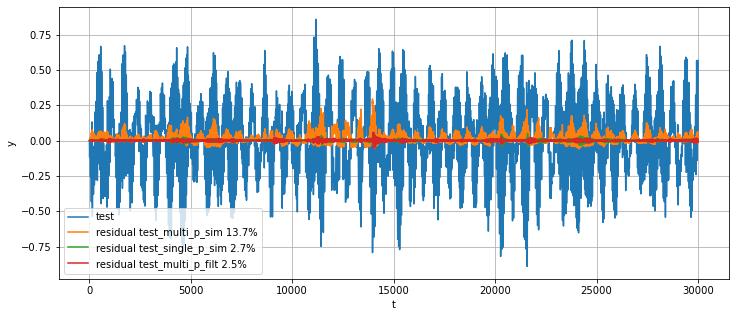

In [19]:
test_multi_p_filt_NRMS = test_multi_p_filt.NRMS(test)
print('test_multi_p_filt=',test_multi_p_filt_NRMS)
test_multi_p_sim_NRMS = test_multi_p_sim.NRMS(test)
print('test_multi_p_sim=',test_multi_p_sim_NRMS)
test_single_p_sim_NRMS = test_single_p_sim.NRMS(test)
print('test_single_p_sim=',test_single_p_sim_NRMS)

plt.figure(figsize=(12,5))
test.plot()
(test-test_multi_p_sim).plot()
(test-test_single_p_sim).plot()
(test-test_multi_p_filt).plot()

plt.legend(['test',f'residual test_multi_p_sim {test_multi_p_sim_NRMS:.1%}',\
            f'residual test_single_p_sim {test_single_p_sim_NRMS:.1%}', \
            f'residual test_multi_p_filt {test_multi_p_filt_NRMS:.1%}'])
plt.grid()
plt.show()

In [25]:
from scipy.io import savemat
d = {'u_test':test.u,'y_test':test.y,\
     'test_single_p_sim':test_single_p_sim.y[:,None], \
     'test_multi_p_filt':test_multi_p_filt.y[:,None],\
     'test_multi_p_sim':test_multi_p_sim.y[:,None]}
savemat('single-and-multi-LPV-test-results.mat',d)




In [28]:
loadmat('single-and-multi-LPV-test-results.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue Mar 15 09:28:05 2022',
 '__version__': '1.0',
 '__globals__': [],
 'u_test': array([[ 0.06170841, 40.        ],
        [ 0.62879373, 39.99205248],
        [ 0.54593754, 39.9705122 ],
        ...,
        [-0.68727306, 37.22219131],
        [-0.39329317, 37.22349167],
        [-0.08935858, 37.22465611]]),
 'y_test': array([[ 0.        , -0.00112241, -0.00686144, ...,  0.03839013,
          0.0276955 ,  0.01983393]]),
 'test_single_p_sim': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04215459],
        [ 0.03190592],
        [ 0.02446045]]),
 'test_multi_p_filt': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04833194],
        [ 0.03864255],
        [ 0.03155755]]),
 'test_multi_p_sim': array([[ 0.        ],
        [-0.00112241],
        [-0.00686144],
        ...,
        [ 0.04985925],
        [ 0.03998259],
        [ 0.0327